# Sessa Empirical Estimator

The Sessa Empirical Estimator (SEE) is a data-driven method designed to estimate the duration of pharmacological prescriptions when this information is missing or incomplete in secondary data sources.

# Dataset

The dataset for this notebook comes from the AdhereR library using the med.events function, which is used to create artificial medical event records.

## med.events: Example medication events records for 100 patients.

### Description

An artificial dataset containing medication events (one per row) for 100 patients (1080 events in total). This is the dataset format appropriate for medication adherence analyses performed with the R package AdhereR. Medication events represent individual records of prescribing or dispensing a specific medication for a patient at a given date. Dosage and medication type is optional (only needed if calculation of adherence or persistence takes into account changes in dosage and type of medication).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [42]:
def load_and_preprocess_data(filepath):
    """
    Load and preprocess the med_events dataset.
    - Reads CSV file.
    - Renames columns.
    - Converts date columns to datetime format.
    """
    df = pd.read_csv(filepath)
    df.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
    df["eksd"] = pd.to_datetime(df["eksd"], format='%m/%d/%Y')
    return df

In [43]:
def filter_medication_data(df, medication):
    """
    Filters dataset for a specific medication based on the ATC column.
    """
    return df[df["ATC"] == medication].copy()

In [44]:
def compute_event_intervals(df):
    """
    Compute event intervals (days between consecutive prescriptions for each patient).
    """
    df.sort_values(by=["pnr", "eksd"], inplace=True)
    df["prev_eksd"] = df.groupby("pnr")["eksd"].shift(1)
    df.dropna(inplace=True)
    df["event_interval"] = (df["eksd"] - df["prev_eksd"]).dt.days
    return df[["pnr", "eksd", "prev_eksd", "event_interval"]]

In [45]:
def compute_ecdf_and_filter(df):
    """
    Compute the empirical cumulative distribution function (ECDF) of event intervals.
    Retain only the lower 80% of values (removing extreme cases).
    """
    sorted_intervals = np.sort(df["event_interval"])
    ecdf = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
    
    # Find the cutoff value for the 80% ECDF threshold
    threshold = np.percentile(sorted_intervals, 80)
    df_filtered = df[df["event_interval"] <= threshold]
    
    # Plot ECDF
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_intervals, ecdf, marker=".", linestyle="none", color="blue", label="ECDF")
    plt.axvline(x=threshold, color="red", linestyle="dashed", linewidth=2, label=f"80% Cutoff: {threshold:.2f}")
    plt.xlabel("Event Interval (Days)", fontsize=12)
    plt.ylabel("ECDF", fontsize=12)
    plt.title("Empirical Cumulative Distribution Function (ECDF) of Event Intervals", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()
    
    return df_filtered

In [47]:
def perform_kmeans_clustering_see(df, n_clusters=3):
    """
    Apply K-Means clustering on log-transformed event intervals based on SEE (Prescription Count vs. Duration).
    """
    # Ensure event_interval is derived from Prescription Count vs Duration
    df["event_interval"] = df["duration"] / df["prescription_count"]

    # Log transformation
    df["log_event_interval"] = np.log1p(df["event_interval"])  

    # Standardize data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[["log_event_interval"]])

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df["cluster"] = kmeans.fit_predict(df_scaled)

    # Compute silhouette score
    silhouette_avg = silhouette_score(df_scaled, df["cluster"])
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg:.4f}")

    # Visualization: Cluster distribution
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df["cluster"], y=df["event_interval"], palette="viridis")
    plt.xlabel("Cluster")
    plt.ylabel("Event Interval (Days)")
    plt.title("K-Means Clustering of Prescription Count vs. Duration")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    return df, kmeans

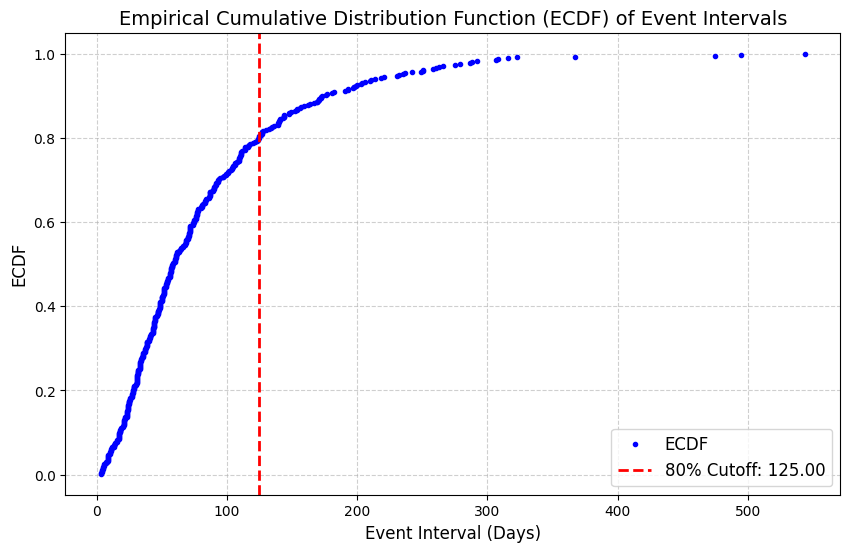

Silhouette Score for 3 clusters: 0.5553


/var/folders/mp/xz0hrky93l3c48ndxn82fv5c0000gn/T/ipykernel_87195/3597696562.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log_event_interval"] = np.log1p(df["event_interval"])  # Apply log transformation
/var/folders/mp/xz0hrky93l3c48ndxn82fv5c0000gn/T/ipykernel_87195/3597696562.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = kmeans.fit_predict(df_scaled)
/var/folders/mp/xz0hrky93l3c48ndxn82fv5c0000gn/T/ipykernel_87195/3597696562.py:21: FutureWarning: 

Passing `palette` witho

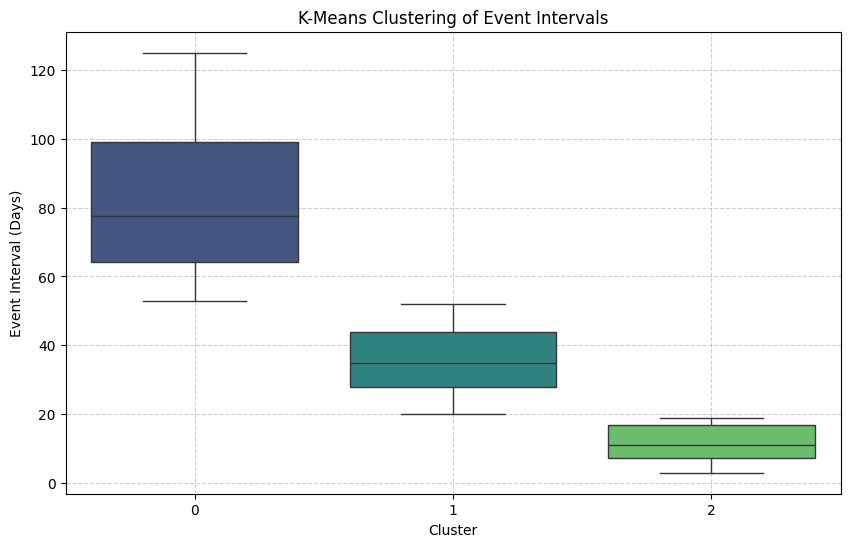

    pnr       eksd  prev_eksd  event_interval
25    2 2036-03-10 2036-01-20              50
26    2 2036-08-01 2036-03-10             144
61    4 2032-11-27 2032-05-01             210
62    4 2033-08-20 2032-11-27             266
63    4 2033-08-30 2033-08-20              10


In [48]:
filepath = "med_events.csv"
df = load_and_preprocess_data(filepath)
df_medA = filter_medication_data(df, "medA")
df_intervals = compute_event_intervals(df_medA)
df_filtered = compute_ecdf_and_filter(df_intervals)
df_clustered, kmeans_model = perform_kmeans_clustering(df_filtered, n_clusters=3)



print(df_intervals.head())